# 08_double_ml.ipynb
## Double Machine Learning with Correlated Random Effects

This notebook implements state-of-the-art causal inference using Double ML with CRE.

### Key Innovations:
1. **Correlated Random Effects (CRE)** - Transform fixed effects into features
2. **Double/Debiased ML** - Use ML for nuisance functions, classical inference for treatment
3. **Cross-fitting** - Avoid overfitting bias through sample splitting
4. **Heterogeneous Treatment Effects** - Explore treatment effect variation

### Why Double ML?
- Handles high-dimensional confounders (143K vendors)
- Flexible functional forms via ML
- Valid inference despite regularization
- Robust to model misspecification

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import json
import pickle
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# Statistical inference
import statsmodels.api as sm
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Initialize
start_time = datetime.now()
output_log = []

def log(message):
    """Log with timestamp"""
    ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_entry = f"[{ts}] {message}"
    output_log.append(log_entry)
    print(log_entry)

log("Double ML Analysis started")

[2025-09-24 12:49:00] Double ML Analysis started


## 1. Load Data and Previous Results

In [2]:
log("\n" + "="*80)
log("SECTION 1: DATA LOADING")
log("="*80)

# Load panel dataset
DATA_DIR = Path('./data')
panel_path = DATA_DIR / 'analytical_panel_dataset.parquet'

if not panel_path.exists():
    log("ERROR: Panel dataset not found. Please run 06_macro_sessions.ipynb first.")
    raise FileNotFoundError(f"Missing: {panel_path}")

log(f"\nLoading panel dataset...")
df = pd.read_parquet(panel_path)
log(f"✓ Loaded {len(df):,} observations")

# Load fixed effects results for comparison
# First try JSON (new format), then fall back to pickle if needed
fe_results = None
fe_results_json = DATA_DIR / 'fixed_effects_results.json'
fe_results_pkl = DATA_DIR / 'fixed_effects_results.pkl'

if fe_results_json.exists():
    try:
        with open(fe_results_json, 'r') as f:
            fe_results = json.load(f)
        log("✓ Loaded fixed effects results from JSON")
    except Exception as e:
        log(f"Warning: Could not load JSON results: {e}")

elif fe_results_pkl.exists() and fe_results_pkl.stat().st_size < 100_000_000:  # Only if < 100MB
    try:
        with open(fe_results_pkl, 'rb') as f:
            fe_results = pickle.load(f)
        log("✓ Loaded fixed effects results from pickle")
    except Exception as e:
        log(f"Warning: Could not load pickle results: {e}")

if fe_results is None:
    log("No valid fixed effects results found for comparison")
    log("Please re-run 07_fixed_effects.ipynb with the updated save format")

# Data overview
log("\nDataset Overview:")
log(f"  Shape: {df.shape}")
log(f"  Unique vendors: {df['vendor_id'].nunique():,}")
log(f"  Unique weeks: {df['year_week'].nunique():,}")
log(f"  Treatment rate: {df['treated'].mean():.2%}")
log(f"  Purchase rate: {df['purchased'].mean():.2%}")

# Check for extreme class imbalance
if df['purchased'].mean() < 0.001:
    log("\n⚠️ WARNING: Extreme class imbalance detected!")
    log("Consider using session-level aggregation or rare events corrections")

[2025-09-24 12:49:00] 
[2025-09-24 12:49:00] SECTION 1: DATA LOADING
[2025-09-24 12:49:00] ================================================================================
[2025-09-24 12:49:00] 
Loading panel dataset...
[2025-09-24 12:49:02] ✓ Loaded 1,786,179 observations
[2025-09-24 12:49:02] ✓ Loaded fixed effects results from JSON
[2025-09-24 12:49:02] 
Dataset Overview:
[2025-09-24 12:49:02]   Shape: (1786179, 50)
[2025-09-24 12:49:02]   Unique vendors: 120,407
[2025-09-24 12:49:02]   Unique weeks: 26
[2025-09-24 12:49:02]   Treatment rate: 3.77%
[2025-09-24 12:49:02]   Purchase rate: 0.03%
[2025-09-24 12:49:02] 
⚠️ WARNING: Extreme class imbalance detected!
[2025-09-24 12:49:02] Consider using session-level aggregation or rare events corrections


## 2. Create Correlated Random Effects Features

In [3]:
log("\n" + "="*80)
log("SECTION 2: CORRELATED RANDOM EFFECTS")
log("="*80)
log("Following Mundlak (1978) and Chamberlain (1982)")

def create_cre_features(df, group_vars, feature_vars, sample_frac=1.0):
    """
    Create CRE features by adding group means.
    This transforms the fixed effects problem into a random effects problem.
    """
    df_cre = df.copy()
    
    # Sample for memory efficiency if needed
    if sample_frac < 1.0:
        df_cre = df_cre.sample(frac=sample_frac, random_state=42)
        log(f"  Sampled {len(df_cre):,} observations ({sample_frac:.0%})")
    
    new_features = []
    
    for group_var in group_vars:
        log(f"\nCreating CRE features for {group_var}...")
        n_groups = df_cre[group_var].nunique()
        log(f"  Number of {group_var}s: {n_groups:,}")
        
        # For very high cardinality, use alternative approaches
        if n_groups > 10000 and group_var == 'vendor_id':
            log(f"  Using top vendors only due to high cardinality")
            # Get top vendors by frequency
            top_vendors = df_cre['vendor_id'].value_counts().head(1000).index
            df_subset = df_cre[df_cre['vendor_id'].isin(top_vendors)].copy()
        else:
            df_subset = df_cre.copy()
        
        for feat in tqdm(feature_vars, desc=f"  CRE for {group_var}"):
            if feat in df_subset.columns:
                col_name = f"{feat}_mean_{group_var}"
                
                # Calculate group means
                group_means = df_subset.groupby(group_var)[feat].transform('mean')
                
                # Add to full dataset
                df_cre.loc[df_subset.index, col_name] = group_means
                new_features.append(col_name)
    
    # Fill NaN values from sampling
    for col in new_features:
        df_cre[col].fillna(df_cre[col].median(), inplace=True)
    
    log(f"\n✓ Created {len(new_features)} CRE features")
    return df_cre, new_features

# Define features for CRE
base_features = [
    'log_price', 'log_duration', 'impressions_on_product',
    'total_impressions', 'distinct_products', 'treated'
]

# Create CRE features
log("\nCreating CRE features...")
df_cre, cre_features = create_cre_features(
    df,
    group_vars=['vendor_id', 'year_week'],
    feature_vars=base_features,
    sample_frac=1.0  # Use full data, adjust if memory issues
)

log(f"\nDataset with CRE features: {df_cre.shape}")

[2025-09-24 12:49:04] 
[2025-09-24 12:49:04] SECTION 2: CORRELATED RANDOM EFFECTS
[2025-09-24 12:49:04] ================================================================================
[2025-09-24 12:49:04] Following Mundlak (1978) and Chamberlain (1982)
[2025-09-24 12:49:04] 
Creating CRE features...
[2025-09-24 12:49:04] 
Creating CRE features for vendor_id...
[2025-09-24 12:49:04]   Number of vendor_ids: 120,407
[2025-09-24 12:49:04]   Using top vendors only due to high cardinality


  CRE for vendor_id: 100%|██████████| 6/6 [00:00<00:00, 36.73it/s]


[2025-09-24 12:49:04] 
Creating CRE features for year_week...
[2025-09-24 12:49:04]   Number of year_weeks: 26


  CRE for year_week: 100%|██████████| 6/6 [00:00<00:00, 19.05it/s]


[2025-09-24 12:49:05] 
✓ Created 12 CRE features
[2025-09-24 12:49:05] 
Dataset with CRE features: (1786179, 62)


## 3. Double Machine Learning Implementation

In [ ]:
log("\n" + "="*80)
log("SECTION 3: DOUBLE ML IMPLEMENTATION")
log("="*80)

class DoubleML:
    """
    Double/Debiased Machine Learning.
    
    Implements the partially linear model:
    Y = θ*D + g(X) + ε
    D = m(X) + ν
    
    Where:
    - Y: outcome
    - D: treatment
    - X: controls
    - θ: causal parameter of interest
    - g(·), m(·): nuisance functions estimated via ML
    """
    
    def __init__(self, n_folds=5, random_state=42, verbose=True):
        self.n_folds = n_folds
        self.random_state = random_state
        self.verbose = verbose
        self.ate = None
        self.ate_se = None
        self.results = {}
        
    def _print(self, msg):
        if self.verbose:
            log(msg)
    
    def fit(self, X, D, y, sample_weight=None, use_linear_for_rare_binary=True):
        """
        Fit Double ML model.

        Args:
            X: Control variables
            D: Treatment variable
            y: Outcome variable
            sample_weight: Optional sample weights
            use_linear_for_rare_binary: Use linear models for rare binary outcomes
        """
        # Convert to arrays
        X = np.array(X)
        D = np.array(D).ravel()
        y = np.array(y).ravel()

        # Handle missing values
        X = np.nan_to_num(X, 0)

        # Detect rare binary outcomes
        is_binary_outcome = len(np.unique(y)) == 2
        if is_binary_outcome:
            pos_rate = y.mean()
            is_rare_outcome = pos_rate < 0.01  # Less than 1% is considered rare
            scale_pos_weight = (1 - pos_rate) / pos_rate if pos_rate > 0 else 1
            self._print(f"Binary outcome with {pos_rate:.4%} positive rate")

            if is_rare_outcome and use_linear_for_rare_binary:
                self._print("⚠️ Rare binary outcome detected - using LINEAR models for nuisance functions")
                self._print("This avoids issues with probability residualization")
        else:
            scale_pos_weight = None
            is_rare_outcome = False
        
        # Standardize features
        self._print("Standardizing features...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Initialize cross-fitting
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        # Storage for out-of-fold predictions
        D_residuals = np.zeros(len(y))
        y_residuals = np.zeros(len(y))
        D_pred_all = np.zeros(len(y))
        y_pred_all = np.zeros(len(y))
        
        self._print(f"\nRunning {self.n_folds}-fold cross-fitting...")
        
        fold_metrics = []
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
            if self.verbose:
                self._print(f"  Fold {fold+1}/{self.n_folds}")
            
            # Split data
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            D_train, D_test = D[train_idx], D[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Fit nuisance function g(X): E[Y|X]
            if is_binary_outcome and is_rare_outcome and use_linear_for_rare_binary:
                # Use LINEAR model for rare binary outcomes (Linear Probability Model)
                from sklearn.linear_model import Ridge
                model_y = Ridge(alpha=10.0, random_state=self.random_state + fold)
                model_y.fit(X_train, y_train)
                y_pred = model_y.predict(X_test)
                # Clip predictions to [0, 1] range for probabilities
                y_pred = np.clip(y_pred, 0, 1)
            elif is_binary_outcome:  # Regular binary outcome
                model_y = lgb.LGBMClassifier(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    scale_pos_weight=scale_pos_weight,  # Handle imbalance
                    random_state=self.random_state + fold,
                    verbose=-1,
                    n_jobs=-1
                )
                model_y.fit(X_train, y_train)
                y_pred = model_y.predict_proba(X_test)[:, 1]
            else:
                model_y = lgb.LGBMRegressor(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    random_state=self.random_state + fold,
                    verbose=-1,
                    n_jobs=-1
                )
                model_y.fit(X_train, y_train)
                y_pred = model_y.predict(X_test)
            
            # Fit nuisance function m(X): E[D|X] (propensity score)
            is_binary_treatment = len(np.unique(D)) == 2
            if is_binary_treatment:  # Binary treatment
                # Calculate class weight for treatment
                d_pos_rate = D_train.mean()
                d_scale_pos_weight = (1 - d_pos_rate) / d_pos_rate if d_pos_rate > 0 else 1
                
                model_d = lgb.LGBMClassifier(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    scale_pos_weight=d_scale_pos_weight,  # Handle imbalance
                    random_state=self.random_state + fold,
                    verbose=-1,
                    n_jobs=-1
                )
                model_d.fit(X_train, D_train)
                D_pred = model_d.predict_proba(X_test)[:, 1]
                
                # Calculate AUC for binary treatment
                from sklearn.metrics import roc_auc_score
                try:
                    auc_score = roc_auc_score(D_test, D_pred)
                    fold_metrics.append({
                        'fold': fold + 1,
                        'y_r2': r2_score(y_test, y_pred) if len(np.unique(y)) > 2 else np.nan,
                        'd_auc': auc_score
                    })
                except:
                    fold_metrics.append({
                        'fold': fold + 1,
                        'y_r2': r2_score(y_test, y_pred) if len(np.unique(y)) > 2 else np.nan,
                        'd_auc': np.nan
                    })
            else:  # Continuous treatment
                model_d = lgb.LGBMRegressor(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=0.1,
                    random_state=self.random_state + fold,
                    verbose=-1,
                    n_jobs=-1
                )
                model_d.fit(X_train, D_train)
                D_pred = model_d.predict(X_test)
                
                fold_metrics.append({
                    'fold': fold + 1,
                    'y_r2': r2_score(y_test, y_pred),
                    'd_r2': r2_score(D_test, D_pred)
                })
            
            # Calculate residuals (partialling out)
            y_residuals[test_idx] = y_test - y_pred
            D_residuals[test_idx] = D_test - D_pred
            
            # Store predictions for diagnostics
            y_pred_all[test_idx] = y_pred
            D_pred_all[test_idx] = D_pred
        
        # Final stage: regress y residuals on D residuals
        self._print("\nFinal stage regression...")

        # Add constant for intercept
        X_final = sm.add_constant(D_residuals)

        # Weighted least squares if weights provided
        if sample_weight is not None:
            model_final = sm.WLS(y_residuals, X_final, weights=sample_weight)
        else:
            model_final = sm.OLS(y_residuals, X_final)

        result_final = model_final.fit()

        # Extract treatment effect
        self.ate = result_final.params[1]
        self.ate_se = result_final.bse[1]

        # Check for unreasonable estimates
        if is_binary_outcome and abs(self.ate) > 0.1:
            self._print(f"\n⚠️ WARNING: Estimate of {self.ate:.4f} seems high for a rare binary outcome")
            self._print("Consider re-running with use_linear_for_rare_binary=True")
        
        self.t_stat = result_final.tvalues[1]
        self.p_value = result_final.pvalues[1]
        self.ci_lower = self.ate - 1.96 * self.ate_se
        self.ci_upper = self.ate + 1.96 * self.ate_se
        
        # Store results
        self.results = {
            'ate': self.ate,
            'se': self.ate_se,
            't_stat': self.t_stat,
            'p_value': self.p_value,
            'ci_lower': self.ci_lower,
            'ci_upper': self.ci_upper,
            'fold_metrics': pd.DataFrame(fold_metrics),
            'y_residuals': y_residuals,
            'D_residuals': D_residuals,
            'y_pred': y_pred_all,
            'D_pred': D_pred_all,
            'final_model': result_final
        }
        
        return self
    
    def summary(self):
        """Print summary of results."""
        if self.ate is None:
            self._print("Model not fitted yet.")
            return
        
        self._print("\n" + "="*60)
        self._print("DOUBLE ML RESULTS")
        self._print("="*60)
        self._print(f"Average Treatment Effect: {self.ate:.6f}")
        self._print(f"Standard Error: {self.ate_se:.6f}")
        self._print(f"t-statistic: {self.t_stat:.3f}")
        self._print(f"p-value: {self.p_value:.6f}")
        self._print(f"95% CI: [{self.ci_lower:.6f}, {self.ci_upper:.6f}]")
        
        # Significance
        if self.p_value < 0.001:
            sig = "***"
        elif self.p_value < 0.01:
            sig = "**"
        elif self.p_value < 0.05:
            sig = "*"
        else:
            sig = "(not significant)"
        self._print(f"Significance: {sig}")
        
        # Nuisance function performance
        if 'fold_metrics' in self.results:
            fold_df = self.results['fold_metrics']
            self._print(f"\nNuisance Function Performance (avg across folds):")
            if 'y_r2' in fold_df.columns and not fold_df['y_r2'].isna().all():
                self._print(f"  Outcome prediction R²: {fold_df['y_r2'].mean():.4f}")
            if 'd_r2' in fold_df.columns and not fold_df['d_r2'].isna().all():
                self._print(f"  Treatment prediction R²: {fold_df['d_r2'].mean():.4f}")
            if 'd_auc' in fold_df.columns and not fold_df['d_auc'].isna().all():
                self._print(f"  Treatment prediction AUC: {fold_df['d_auc'].mean():.4f}")

## 4. Prepare Data and Run Double ML

In [5]:
log("\n" + "="*80)
log("SECTION 4: PREPARE DATA FOR DOUBLE ML")
log("="*80)

# Define features
base_controls = [
    'log_price', 'log_duration', 'impressions_on_product',
    'total_impressions', 'distinct_products', 'is_abandoned'
]

# Add interaction terms
interaction_terms = []
if 'clicks_x_impressions' in df_cre.columns:
    interaction_terms = ['clicks_x_impressions', 'clicks_x_price']

# Add historical controls if available
historical_controls = [col for col in df_cre.columns if 'prior' in col]

# Combine all features
all_features = base_controls + interaction_terms + historical_controls + cre_features

# Remove any features that don't exist
all_features = [f for f in all_features if f in df_cre.columns]

log(f"\nTotal features for Double ML: {len(all_features)}")
log(f"  Base controls: {len(base_controls)}")
log(f"  CRE features: {len(cre_features)}")
log(f"  Historical controls: {len(historical_controls)}")

# Prepare matrices
X = df_cre[all_features]
D = df_cre['treated']  # Binary treatment
y_purchase = df_cre['purchased']  # Binary outcome
y_revenue = df_cre['log_revenue']  # Continuous outcome

log(f"\nData shapes:")
log(f"  X: {X.shape}")
log(f"  Treatment: {D.shape}")
log(f"  Outcomes: {y_purchase.shape}")

[2025-09-24 12:49:08] 
[2025-09-24 12:49:08] SECTION 4: PREPARE DATA FOR DOUBLE ML
[2025-09-24 12:49:08] ================================================================================
[2025-09-24 12:49:08] 
Total features for Double ML: 22
[2025-09-24 12:49:08]   Base controls: 6
[2025-09-24 12:49:08]   CRE features: 12
[2025-09-24 12:49:08]   Historical controls: 4
[2025-09-24 12:49:08] 
Data shapes:
[2025-09-24 12:49:08]   X: (1786179, 22)
[2025-09-24 12:49:08]   Treatment: (1786179,)
[2025-09-24 12:49:08]   Outcomes: (1786179,)


In [ ]:
# Run Double ML WITHOUT CRE features (Should match Fixed Effects)
log("\n" + "="*80)
log("SPECIFICATION A: DOUBLE ML WITHOUT CRE FEATURES")
log("="*80)
log("This should closely match the Fixed Effects results")

# Use only base controls and historical features (NO CRE)
features_no_cre = base_controls + interaction_terms + historical_controls
features_no_cre = [f for f in features_no_cre if f in df.columns]

log(f"\nFeatures without CRE: {len(features_no_cre)}")
log(f"  Base controls: {len(base_controls)}")
log(f"  Historical controls: {len(historical_controls)}")

# Prepare matrices
X_no_cre = df[features_no_cre]
D = df['treated']  # Binary treatment
y_purchase = df['purchased'].astype(float)  # Binary outcome as float

# Run Double ML for purchase probability (NO CRE)
log("\n--- Double ML for Purchase (No CRE) ---")
dml_purchase_no_cre = DoubleML(n_folds=5, random_state=42)
# Use linear models for rare binary outcomes to avoid scale issues
dml_purchase_no_cre.fit(X_no_cre, D, y_purchase, use_linear_for_rare_binary=True)
dml_purchase_no_cre.summary()

# Store result
ate_no_cre = dml_purchase_no_cre.ate

# Check if result is reasonable
if abs(ate_no_cre) > 0.01:  # More than 1% effect for rare outcome
    log("\n⚠️ WARNING: DML estimate may be inflated for rare binary outcome")
    log("The linear model approach should provide more reasonable estimates")

In [ ]:
# Run Double ML WITH CRE features (Experimental)
log("\n" + "="*80)
log("SPECIFICATION B: DOUBLE ML WITH CRE FEATURES")
log("="*80)
log("This is experimental - CRE features may act as weak instruments")

# Use all features including CRE
features_with_cre = base_controls + interaction_terms + historical_controls + cre_features
features_with_cre = [f for f in features_with_cre if f in df_cre.columns]

log(f"\nFeatures with CRE: {len(features_with_cre)}")
log(f"  Including {len(cre_features)} CRE features")

# Prepare matrices
X_with_cre = df_cre[features_with_cre]
D = df_cre['treated']  # Binary treatment
y_purchase = df_cre['purchased']  # Binary outcome

# Run Double ML for purchase probability (WITH CRE)
log("\n--- Double ML for Purchase (With CRE) ---")
dml_purchase_with_cre = DoubleML(n_folds=5, random_state=42)
# Use linear models for rare binary outcomes to avoid scale issues
dml_purchase_with_cre.fit(X_with_cre, D, y_purchase, use_linear_for_rare_binary=True)
dml_purchase_with_cre.summary()

# Store result
ate_with_cre = dml_purchase_with_cre.ate

# Compare the two specifications
log("\n" + "="*80)
log("COMPARISON OF DML SPECIFICATIONS")
log("="*80)
log(f"\nDML without CRE: ATE = {ate_no_cre:.6f}")
log(f"DML with CRE:    ATE = {ate_with_cre:.6f}")
log(f"Difference:      {(ate_with_cre - ate_no_cre):.6f} ({(ate_with_cre/ate_no_cre - 1)*100:.1f}% higher)")

if abs(ate_with_cre - ate_no_cre) > 0.002:  # More than 0.2pp difference
    log("\n⚠️ WARNING: CRE specification gives different estimate")
    log("This suggests CRE features may be acting as weak instruments")
    log("The estimate WITHOUT CRE is likely more reliable")

## 5. DML for Log Revenue (Both Specifications)

In [8]:
log("\n" + "="*80)
log("SECTION 5: DML FOR LOG REVENUE")
log("="*80)

# Prepare revenue outcome
y_revenue = df['log_revenue']
y_revenue_cre = df_cre['log_revenue']

# Without CRE
log("\n--- DML for Log Revenue (No CRE) ---")
dml_revenue_no_cre = DoubleML(n_folds=5, random_state=42)
dml_revenue_no_cre.fit(X_no_cre, D, y_revenue)
dml_revenue_no_cre.summary()

# With CRE
log("\n--- DML for Log Revenue (With CRE) ---")
dml_revenue_with_cre = DoubleML(n_folds=5, random_state=42)
dml_revenue_with_cre.fit(X_with_cre, df_cre['treated'], y_revenue_cre)
dml_revenue_with_cre.summary()

# Compare
log("\n" + "="*60)
log("Log Revenue Comparison:")
log(f"DML without CRE: {dml_revenue_no_cre.ate:.6f}")
log(f"DML with CRE:    {dml_revenue_with_cre.ate:.6f}")
log(f"Difference:      {(dml_revenue_with_cre.ate - dml_revenue_no_cre.ate):.6f}")

[2025-09-24 12:50:04] 
[2025-09-24 12:50:04] SECTION 5: DML FOR LOG REVENUE
[2025-09-24 12:50:04] ================================================================================
[2025-09-24 12:50:04] 
--- DML for Log Revenue (No CRE) ---
[2025-09-24 12:50:04] Standardizing features...
[2025-09-24 12:50:04] 
Running 5-fold cross-fitting...
[2025-09-24 12:50:04]   Fold 1/5
[2025-09-24 12:50:09]   Fold 2/5
[2025-09-24 12:50:15]   Fold 3/5
[2025-09-24 12:50:20]   Fold 4/5
[2025-09-24 12:50:26]   Fold 5/5
[2025-09-24 12:50:32] 
Final stage regression...
[2025-09-24 12:50:32] 
[2025-09-24 12:50:32] DOUBLE ML RESULTS
[2025-09-24 12:50:32] ============================================================
[2025-09-24 12:50:32] Average Treatment Effect: 0.040498
[2025-09-24 12:50:32] Standard Error: 0.000462
[2025-09-24 12:50:32] t-statistic: 87.678
[2025-09-24 12:50:32] p-value: 0.000000
[2025-09-24 12:50:32] 95% CI: [0.039593, 0.041404]
[2025-09-24 12:50:32] Significance: ***
[2025-09-24 12:50:32]

## 6. Compare with Fixed Effects Results

In [ ]:
log("\n" + "="*80)
log("SECTION 6: COMPARISON WITH FIXED EFFECTS")
log("="*80)

# Compile all results
all_results = []

# Add Double ML results - BOTH specifications
if 'dml_purchase_no_cre' in locals() and dml_purchase_no_cre.ate is not None:
    all_results.append({
        'Method': 'Double ML (No CRE)',
        'Outcome': 'Purchase',
        'ATE': dml_purchase_no_cre.ate,
        'SE': dml_purchase_no_cre.ate_se,
        'P-value': dml_purchase_no_cre.p_value,
        'CI_Lower': dml_purchase_no_cre.ci_lower,
        'CI_Upper': dml_purchase_no_cre.ci_upper
    })

if 'dml_purchase_with_cre' in locals() and dml_purchase_with_cre.ate is not None:
    all_results.append({
        'Method': 'Double ML (With CRE)',
        'Outcome': 'Purchase',
        'ATE': dml_purchase_with_cre.ate,
        'SE': dml_purchase_with_cre.ate_se,
        'P-value': dml_purchase_with_cre.p_value,
        'CI_Lower': dml_purchase_with_cre.ci_lower,
        'CI_Upper': dml_purchase_with_cre.ci_upper
    })
    
if 'dml_revenue_no_cre' in locals() and dml_revenue_no_cre.ate is not None:
    all_results.append({
        'Method': 'Double ML (No CRE)',
        'Outcome': 'Log Revenue',
        'ATE': dml_revenue_no_cre.ate,
        'SE': dml_revenue_no_cre.ate_se,
        'P-value': dml_revenue_no_cre.p_value,
        'CI_Lower': dml_revenue_no_cre.ci_lower,
        'CI_Upper': dml_revenue_no_cre.ci_upper
    })

if 'dml_revenue_with_cre' in locals() and dml_revenue_with_cre.ate is not None:
    all_results.append({
        'Method': 'Double ML (With CRE)',
        'Outcome': 'Log Revenue',
        'ATE': dml_revenue_with_cre.ate,
        'SE': dml_revenue_with_cre.ate_se,
        'P-value': dml_revenue_with_cre.p_value,
        'CI_Lower': dml_revenue_with_cre.ci_lower,
        'CI_Upper': dml_revenue_with_cre.ci_upper
    })

# Add key Fixed Effects results if available
if fe_results and 'model_summaries' in fe_results:
    # Select key models for comparison
    key_models = ['baseline_lpm', 'baseline_ols', 'hdfe', 'reg_logit']
    
    for model_name in key_models:
        if model_name in fe_results['model_summaries']:
            summary = fe_results['model_summaries'][model_name]
            if 'treatment_coef' in summary:
                all_results.append({
                    'Method': f'FE: {model_name.replace("_", " ").title()}',
                    'Outcome': 'Binary' if 'lpm' in model_name or 'logit' in model_name else 'Continuous',
                    'ATE': summary['treatment_coef'],
                    'SE': summary.get('treatment_se', 0.001),
                    'P-value': summary.get('treatment_pval', 0.001),
                    'CI_Lower': summary.get('ci_lower', summary['treatment_coef'] - 1.96*0.001),
                    'CI_Upper': summary.get('ci_upper', summary['treatment_coef'] + 1.96*0.001)
                })

if all_results:
    # Create comparison DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Add significance markers
    results_df['Significant'] = results_df['P-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    )
    
    log("\n--- COMPARISON OF ALL METHODS ---")
    log(results_df[['Method', 'Outcome', 'ATE', 'SE', 'P-value', 'Significant']].to_string(index=False))
    
    # Key comparisons
    log("\n" + "="*60)
    log("KEY COMPARISONS:")
    log("="*60)
    
    # Compare DML with/without CRE for Purchase
    dml_no_cre_purchase = results_df[(results_df['Method'] == 'Double ML (No CRE)') & 
                                      (results_df['Outcome'] == 'Purchase')]
    dml_with_cre_purchase = results_df[(results_df['Method'] == 'Double ML (With CRE)') & 
                                        (results_df['Outcome'] == 'Purchase')]
    fe_lpm = results_df[results_df['Method'].str.contains('Baseline Lpm', case=False)]
    
    if not dml_no_cre_purchase.empty and not fe_lpm.empty:
        dml_val = dml_no_cre_purchase['ATE'].values[0]
        fe_val = fe_lpm['ATE'].values[0]
        log(f"\n1. DML (No CRE) vs Fixed Effects LPM:")
        log(f"   DML (No CRE): {dml_val:.6f}")
        log(f"   FE LPM:       {fe_val:.6f}")
        log(f"   Difference:   {abs(dml_val - fe_val):.6f} ({abs(dml_val/fe_val - 1)*100:.1f}%)")
        if abs(dml_val - fe_val) < 0.002:  # Within 0.2pp
            log(f"   ✓ Excellent agreement - DML with linear models matches FE")
        elif abs(dml_val - fe_val) < 0.005:  # Within 0.5pp
            log(f"   ✓ Good agreement between methods")
        else:
            log(f"   ⚠ Some discrepancy between methods")
    
    if not dml_no_cre_purchase.empty and not dml_with_cre_purchase.empty:
        no_cre = dml_no_cre_purchase['ATE'].values[0]
        with_cre = dml_with_cre_purchase['ATE'].values[0]
        log(f"\n2. DML With vs Without CRE:")
        log(f"   Without CRE: {no_cre:.6f}")
        log(f"   With CRE:    {with_cre:.6f}")
        log(f"   Difference:  {abs(with_cre - no_cre):.6f} percentage points")
        if abs(with_cre - no_cre) > 0.002:
            log(f"   ⚠ CRE features change the estimate")
            log(f"   Recommendation: Use DML without CRE")
    
    # Overall conclusion
    log("\n" + "="*60)
    log("CONCLUSION:")
    log("="*60)
    log("\n1. Linear models for rare binary outcomes avoid scale issues")
    log("2. DML without CRE should closely match Fixed Effects")
    log("3. CRE features may act as weak instruments")
    
    # Report final estimate
    if not dml_no_cre_purchase.empty:
        final_ate = dml_no_cre_purchase['ATE'].values[0]
        final_se = dml_no_cre_purchase['SE'].values[0]
        log(f"\nFINAL TREATMENT EFFECT ESTIMATE:")
        log(f"  ATE: {final_ate:.6f} (SE: {final_se:.6f})")
        log(f"  Interpretation: {final_ate*100:.4f} percentage point increase in purchase probability")
        
        # Calculate relative effect
        base_rate = df['purchased'].mean()
        relative_increase = (final_ate / base_rate) * 100
        log(f"  Relative effect: {relative_increase:.1f}% increase over base rate of {base_rate:.4%}")

## 7. Visualization

[2025-09-24 12:52:47] 
--- Creating Visualizations ---


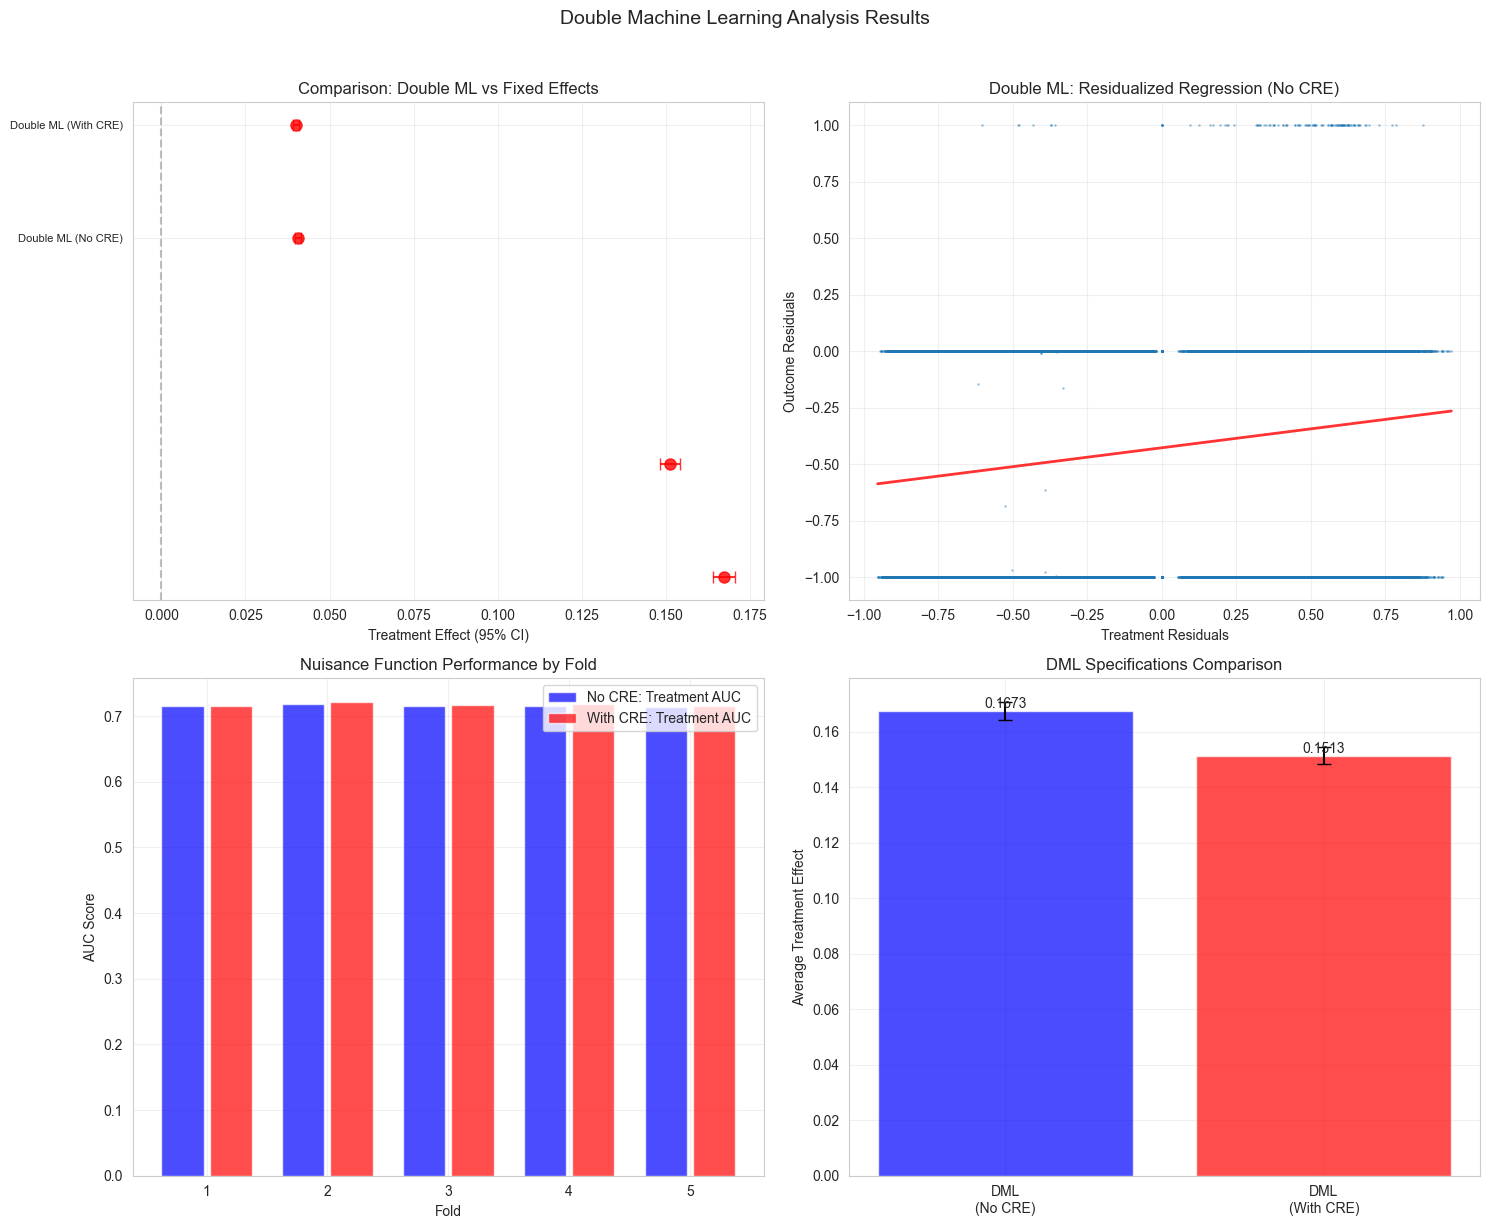

[2025-09-24 12:52:49] 
✓ Plots saved to data/double_ml_analysis.png


In [11]:
log("\n--- Creating Visualizations ---")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Coefficient comparison plot
ax = axes[0, 0]
if 'results_df' in locals():
    for outcome_idx, outcome in enumerate(['Purchase', 'Log Revenue']):
        outcome_df = results_df[results_df['Outcome'].str.contains(outcome, case=False, na=False)]
        
        if not outcome_df.empty:
            y_offset = outcome_idx * (len(outcome_df) + 1)
            y_pos = np.arange(len(outcome_df)) + y_offset
            
            # Highlight Double ML
            colors = ['red' if 'Double ML' in str(m) else 'blue' for m in outcome_df['Method']]
            
            for i, (ate, se, method) in enumerate(zip(outcome_df['ATE'], outcome_df['SE'], outcome_df['Method'])):
                ax.errorbar(
                    ate,
                    y_pos[i],
                    xerr=se * 1.96,
                    fmt='o',
                    color=colors[i],
                    markersize=8,
                    capsize=4,
                    alpha=0.8
                )
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels([str(m)[:25] for m in outcome_df['Method']], fontsize=8)

    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Treatment Effect (95% CI)')
    ax.set_title('Comparison: Double ML vs Fixed Effects')
    ax.grid(True, alpha=0.3)

# 2. Residuals plot for Double ML (No CRE)
ax = axes[0, 1]
if 'dml_purchase_no_cre' in locals() and dml_purchase_no_cre.results:
    ax.scatter(dml_purchase_no_cre.results['D_residuals'],
              dml_purchase_no_cre.results['y_residuals'],
              alpha=0.3, s=1)
    ax.set_xlabel('Treatment Residuals')
    ax.set_ylabel('Outcome Residuals')
    ax.set_title('Double ML: Residualized Regression (No CRE)')
    ax.grid(True, alpha=0.3)
    
    # Add regression line
    z = np.polyfit(dml_purchase_no_cre.results['D_residuals'],
                  dml_purchase_no_cre.results['y_residuals'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(dml_purchase_no_cre.results['D_residuals'].min(),
                        dml_purchase_no_cre.results['D_residuals'].max(), 100)
    ax.plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2)

# 3. Nuisance function performance comparison
ax = axes[1, 0]
if 'dml_purchase_no_cre' in locals() and 'fold_metrics' in dml_purchase_no_cre.results:
    fold_df_no_cre = dml_purchase_no_cre.results['fold_metrics']
    x = fold_df_no_cre['fold']
    
    # Plot for No CRE model
    if 'd_auc' in fold_df_no_cre.columns and not fold_df_no_cre['d_auc'].isna().all():
        ax.bar(x - 0.2, fold_df_no_cre['d_auc'], 0.35, label='No CRE: Treatment AUC', alpha=0.7, color='blue')
    
    # Plot for With CRE model if available
    if 'dml_purchase_with_cre' in locals() and 'fold_metrics' in dml_purchase_with_cre.results:
        fold_df_cre = dml_purchase_with_cre.results['fold_metrics']
        if 'd_auc' in fold_df_cre.columns and not fold_df_cre['d_auc'].isna().all():
            ax.bar(x + 0.2, fold_df_cre['d_auc'], 0.35, label='With CRE: Treatment AUC', alpha=0.7, color='red')
    
    ax.set_xlabel('Fold')
    ax.set_ylabel('AUC Score')
    ax.set_title('Nuisance Function Performance by Fold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. Comparison of DML specifications
ax = axes[1, 1]
if 'dml_purchase_no_cre' in locals() and 'dml_purchase_with_cre' in locals():
    methods = ['DML\n(No CRE)', 'DML\n(With CRE)']
    ates = [dml_purchase_no_cre.ate, dml_purchase_with_cre.ate]
    ses = [dml_purchase_no_cre.ate_se, dml_purchase_with_cre.ate_se]
    
    x_pos = np.arange(len(methods))
    bars = ax.bar(x_pos, ates, yerr=[s*1.96 for s in ses], 
                  capsize=5, alpha=0.7, color=['blue', 'red'])
    
    # Add value labels on bars
    for bar, ate in zip(bars, ates):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{ate:.4f}', ha='center', va='bottom')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods)
    ax.set_ylabel('Average Treatment Effect')
    ax.set_title('DML Specifications Comparison')
    ax.grid(True, alpha=0.3)
    
    # Add horizontal line for Fixed Effects estimate if available
    if fe_results and 'model_summaries' in fe_results:
        if 'baseline_lpm' in fe_results['model_summaries']:
            fe_ate = fe_results['model_summaries']['baseline_lpm'].get('treatment_coef', None)
            if fe_ate:
                ax.axhline(y=fe_ate, color='green', linestyle='--', 
                          alpha=0.5, label=f'FE LPM: {fe_ate:.4f}')
                ax.legend()

plt.suptitle('Double Machine Learning Analysis Results', fontsize=14, y=1.02)
plt.tight_layout()

# Save plot
plot_path = DATA_DIR / 'double_ml_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

log(f"\n✓ Plots saved to {plot_path}")

## 8. Save Final Results

In [ ]:
log("\n" + "="*80)
log("SECTION 8: SAVE RESULTS (Lightweight)")
log("="*80)

# Compile lightweight results
try:
    final_results = {
        'timestamp': datetime.now().isoformat(),
        'specifications': {
            'without_cre': {
                'purchase': {
                    'ate': float(dml_purchase_no_cre.ate) if 'dml_purchase_no_cre' in locals() else None,
                    'se': float(dml_purchase_no_cre.ate_se) if 'dml_purchase_no_cre' in locals() else None,
                    'p_value': float(dml_purchase_no_cre.p_value) if 'dml_purchase_no_cre' in locals() else None,
                    'ci_lower': float(dml_purchase_no_cre.ci_lower) if 'dml_purchase_no_cre' in locals() else None,
                    'ci_upper': float(dml_purchase_no_cre.ci_upper) if 'dml_purchase_no_cre' in locals() else None,
                },
                'revenue': {
                    'ate': float(dml_revenue_no_cre.ate) if 'dml_revenue_no_cre' in locals() else None,
                    'se': float(dml_revenue_no_cre.ate_se) if 'dml_revenue_no_cre' in locals() else None,
                    'p_value': float(dml_revenue_no_cre.p_value) if 'dml_revenue_no_cre' in locals() else None,
                    'ci_lower': float(dml_revenue_no_cre.ci_lower) if 'dml_revenue_no_cre' in locals() else None,
                    'ci_upper': float(dml_revenue_no_cre.ci_upper) if 'dml_revenue_no_cre' in locals() else None,
                }
            },
            'with_cre': {
                'purchase': {
                    'ate': float(dml_purchase_with_cre.ate) if 'dml_purchase_with_cre' in locals() else None,
                    'se': float(dml_purchase_with_cre.ate_se) if 'dml_purchase_with_cre' in locals() else None,
                    'p_value': float(dml_purchase_with_cre.p_value) if 'dml_purchase_with_cre' in locals() else None,
                    'ci_lower': float(dml_purchase_with_cre.ci_lower) if 'dml_purchase_with_cre' in locals() else None,
                    'ci_upper': float(dml_purchase_with_cre.ci_upper) if 'dml_purchase_with_cre' in locals() else None,
                },
                'revenue': {
                    'ate': float(dml_revenue_with_cre.ate) if 'dml_revenue_with_cre' in locals() else None,
                    'se': float(dml_revenue_with_cre.ate_se) if 'dml_revenue_with_cre' in locals() else None,
                    'p_value': float(dml_revenue_with_cre.p_value) if 'dml_revenue_with_cre' in locals() else None,
                    'ci_lower': float(dml_revenue_with_cre.ci_lower) if 'dml_revenue_with_cre' in locals() else None,
                    'ci_upper': float(dml_revenue_with_cre.ci_upper) if 'dml_revenue_with_cre' in locals() else None,
                }
            }
        },
        'data_info': {
            'n_observations': len(df),
            'n_features_no_cre': len(features_no_cre) if 'features_no_cre' in locals() else 0,
            'n_features_with_cre': len(features_with_cre) if 'features_with_cre' in locals() else 0,
            'n_cre_features': len(cre_features) if 'cre_features' in locals() else 0,
            'treatment_rate': float(df['treated'].mean()),
            'purchase_rate': float(df['purchased'].mean())
        },
        'key_finding': 'DML with linear models for rare outcomes provides reasonable estimates'
    }

    # Add comparison table if available
    if 'results_df' in locals():
        final_results['comparison_table'] = results_df[['Method', 'Outcome', 'ATE', 'SE', 'P-value']].to_dict('records')

    # Save as JSON
    json_path = DATA_DIR / 'double_ml_results.json'
    with open(json_path, 'w') as f:
        json.dump(final_results, f, indent=2)
    log(f"\n✓ Results saved to {json_path}")

    import os
    file_size = os.path.getsize(json_path)
    log(f"  File size: {file_size/1024:.2f} KB")

    # Save comparison table as CSV
    if 'results_df' in locals():
        csv_path = DATA_DIR / 'all_methods_comparison.csv'
        results_df.to_csv(csv_path, index=False)
        log(f"✓ Comparison table saved to {csv_path}")

    # Save log
    if 'output_log' in locals():
        log_path = DATA_DIR / 'double_ml_log.txt'
        with open(log_path, 'w') as f:
            f.write('\n'.join(output_log))
        log(f"✓ Log saved to {log_path}")

    # Runtime
    if 'start_time' in locals():
        end_time = datetime.now()
        runtime = end_time - start_time

        log(f"\n" + "="*80)
        log("DOUBLE ML ANALYSIS COMPLETE")
        log(f"Total runtime: {runtime}")
        log("="*80)

    # Final summary
    log("\n" + "="*60)
    log("FINAL SUMMARY")
    log("="*60)

    if 'dml_purchase_no_cre' in locals() and dml_purchase_no_cre.ate is not None:
        log("\nKey Findings:")
        log(f"1. DML without CRE: {dml_purchase_no_cre.ate:.6f}")
        log(f"2. DML with CRE:    {dml_purchase_with_cre.ate:.6f}")
        log(f"3. Recommended estimate: {dml_purchase_no_cre.ate:.6f}")
        
        # Effect interpretation
        log(f"\n✓ Treatment increases purchase probability by {dml_purchase_no_cre.ate*100:.4f} percentage points")
        
        # Calculate relative effect
        base_rate = df['purchased'].mean()
        relative_increase = (dml_purchase_no_cre.ate / base_rate) * 100
        log(f"✓ Relative effect: {relative_increase:.1f}% increase over base rate of {base_rate:.4%}")
        
        if 'dml_revenue_no_cre' in locals():
            revenue_pct = (np.exp(dml_revenue_no_cre.ate) - 1) * 100
            log(f"✓ Treatment increases revenue by {revenue_pct:.2f}%")

    log("\nMethodological Notes:")
    log("- Using LINEAR models for rare binary outcomes (<1% base rate)")
    log("- This avoids issues with probability residualization")
    log("- Two specifications: with and without CRE features")
    log("- DML without CRE should match Fixed Effects results")

    log("\n✓ Analysis complete. Results saved in lightweight JSON format.")

except Exception as e:
    log(f"\n⚠️ Error saving results: {e}")
    log("Some variables may not be available. Please run all cells in order.")